In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Lambda, BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

In [2]:
# 디렉토리 설정
unlabeled_data_dir = r"C:/coding/kamp/unlabeled.csv"
unlabeled_df = pd.read_csv(unlabeled_data_dir)

labeled_data_dir = r"C:/coding/kamp/labeled.csv"
labeled_df = pd.read_csv(labeled_data_dir)

In [3]:
# 디스플레이 옵션 설정
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.unicode.east_asian_width', True)

In [4]:
def useless_data_drop(dataframe):
    # 중복 데이터 제거
    dataframe = dataframe.drop_duplicates()
    # 1차 분석 후 불필요 데이터 제거
    dataframe.drop("_id", axis=1, inplace=True)
    dataframe.drop("PART_FACT_PLAN_DATE", axis=1, inplace=True)
    # 분석모델에 쓸모 없는 데이터 제거
    for column, value in dataframe.std().iteritems():
        if value == 0:
            dataframe.drop(f"{column}", axis=1, inplace=True)
    # Datetime으로 변경
    dataframe["TimeStamp"] = pd.to_datetime(dataframe['TimeStamp'], yearfirst=True)
    return dataframe

In [5]:
# 필요없는 데이터 제거
unlabeled_df = useless_data_drop(unlabeled_df)
unlabeled_df.drop("Unnamed: 0", axis=1, inplace=True)


labeled_df = useless_data_drop(labeled_df)

C:\Users\wlsry\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-4-d1845d81cc9f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["TimeStamp"] = pd.to_datetime(dataframe['TimeStamp'], yearfirst=True)


In [6]:
# 장비, 제품 별 분류 함수
def div_pa_eq(dataframe, part_name, equip_name):
    part_name_filter = dataframe["PART_NAME"].str.contains(part_name)
    equip_name_filter = dataframe["EQUIP_NAME"].str.contains(equip_name)

    return dataframe[part_name_filter & equip_name_filter]

In [7]:
# CN7_우진650톤 데이터 추출
CN7_filter = unlabeled_df["PART_NAME"].str.contains("CN7")
Eq650_filter = unlabeled_df["EQUIP_NAME"].str.contains("650")
ERR_filter = unlabeled_df["ERR_FACT_QTY"] <= 0  # 잡음제거 오토인코더는 정상데이터로 학습시키므로 ERR기준으로 데이터 분리
SOP_filter = unlabeled_df["Switch_Over_Position"] == 0  # Switch_Over_Position 0인지 아닌지에 따라 공정이 달라지는듯

CN7_650T_df = unlabeled_df[CN7_filter & Eq650_filter & ERR_filter & SOP_filter]

In [8]:
# 이상치 측정 함수
def outlier(x):
    Q1 = x.quantile(1/4)
    Q3 = x.quantile(3/4)
    IQR = Q3 - Q1
    LL = Q1 - (1.5*IQR)
    UU = Q3 + (1.5*IQR)
    outlier = (x < LL) | (x > UU)
    return outlier

# unlabeled데이터 분석 후 사용 안하는 데이터 제거

In [9]:
# 종속 변수 제거
CN7_650T_df["Packing_Time"] = CN7_650T_df["Injection_Time"] - CN7_650T_df["Filling_Time"]
CN7_650T_df["Avg_Mold_Temperature"] = (CN7_650T_df["Mold_Temperature_3"] + CN7_650T_df["Mold_Temperature_4"])/2
unlabeled_CN7_650T_train = CN7_650T_df.drop(["Barrel_Temperature_7", "PART_FACT_SERIAL", "PART_NO", "PART_NAME", "EQUIP_CD", "EQUIP_NAME", "ERR_FACT_QTY", "TimeStamp","Injection_Time", "Switch_Over_Position", "Mold_Temperature_3", "Mold_Temperature_4" ], axis=1)
# unlabeled_CN7_650T_train = CN7_650T_df.drop(["PART_FACT_SERIAL", "PART_NO", "PART_NAME", "EQUIP_CD", "EQUIP_NAME", "Cycle_Time", "ERR_FACT_QTY", "TimeStamp","Injection_Time", "Clamp_Close_Time", "Switch_Over_Position", "Clamp_Open_Position", "Max_Back_Pressure", "Hopper_Temperature", "Barrel_Temperature_1", "Barrel_Temperature_3", "Barrel_Temperature_4","Barrel_Temperature_5", "Barrel_Temperature_6", "Barrel_Temperature_7", "Mold_Temperature_3", "Mold_Temperature_4" ], axis=1)

unlabeled_CN7_650T_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2135 entries, 500632 to 775136
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Filling_Time              2135 non-null   float64
 1   Plasticizing_Time         2135 non-null   float64
 2   Cycle_Time                2135 non-null   float64
 3   Clamp_Close_Time          2135 non-null   float64
 4   Cushion_Position          2135 non-null   float64
 5   Plasticizing_Position     2135 non-null   float64
 6   Clamp_Open_Position       2135 non-null   float64
 7   Max_Injection_Speed       2135 non-null   float64
 8   Max_Screw_RPM             2135 non-null   float64
 9   Average_Screw_RPM         2135 non-null   float64
 10  Max_Injection_Pressure    2135 non-null   float64
 11  Max_Switch_Over_Pressure  2135 non-null   float64
 12  Max_Back_Pressure         2135 non-null   float64
 13  Average_Back_Pressure     2135 non-null   float64
 14  B

<ipython-input-9-dad24cd2b492>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CN7_650T_df["Packing_Time"] = CN7_650T_df["Injection_Time"] - CN7_650T_df["Filling_Time"]
<ipython-input-9-dad24cd2b492>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CN7_650T_df["Avg_Mold_Temperature"] = (CN7_650T_df["Mold_Temperature_3"] + CN7_650T_df["Mold_Temperature_4"])/2


# labeled데이터 분석 후 사용 안하는 데이터 제거

In [10]:
# CN7_우진650톤 데이터 추출
CN7_filter = labeled_df["PART_NAME"].str.contains("CN7")
Eq650_filter = labeled_df["EQUIP_NAME"].str.contains("650")

labeled_df = labeled_df[CN7_filter & Eq650_filter]

# # Pass or Fail, Reason 데이터를 더미 변수로 변환
# label_encoder = preprocessing.LabelEncoder()
# onehot_encoder = preprocessing.OneHotEncoder()
# onehot_Reason = label_encoder.fit_transform(labeled_df["Reason"])
# labeled_df["Reason"] = onehot_Reason

# 데이터 분석 후 종속 변수 제거
labeled_df["Packing_Time"] = labeled_df["Injection_Time"] - labeled_df["Filling_Time"]
labeled_df["Avg_Mold_Temperature"] = (labeled_df["Mold_Temperature_3"] + labeled_df["Mold_Temperature_4"])/2
labeled_df = labeled_df.drop(["PART_FACT_SERIAL", "PART_NAME", "EQUIP_CD", "EQUIP_NAME", "TimeStamp","Injection_Time", "Switch_Over_Position", "Mold_Temperature_3", "Mold_Temperature_4","Barrel_Temperature_7" ], axis=1)
# labeled_df = labeled_df.drop(["PART_FACT_SERIAL", "PART_NAME", "EQUIP_CD", "EQUIP_NAME", "Cycle_Time", "TimeStamp","Injection_Time", "Clamp_Close_Time", "Switch_Over_Position", "Clamp_Open_Position", "Max_Back_Pressure", "Hopper_Temperature", "Barrel_Temperature_1", "Barrel_Temperature_3", "Barrel_Temperature_4","Barrel_Temperature_5", "Barrel_Temperature_6", "Barrel_Temperature_7", "Mold_Temperature_3", "Mold_Temperature_4" ], axis=1)


# PassFail 분류
labeled_df_Y = labeled_df[labeled_df["PassOrFail"].str.contains("Y")]
labeled_df_N = labeled_df[labeled_df["PassOrFail"].str.contains("N")]
labeled_df_Y.drop(["PassOrFail", "Reason"], axis=1, inplace=True)
labeled_df_N.drop("PassOrFail", axis=1, inplace=True)
labeled_df_N_test = labeled_df_N.drop("Reason", axis=1)

labeled_df_Y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3946 entries, 0 to 5157
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Filling_Time              3946 non-null   float64
 1   Plasticizing_Time         3946 non-null   float64
 2   Cycle_Time                3946 non-null   float64
 3   Clamp_Close_Time          3946 non-null   float64
 4   Cushion_Position          3946 non-null   float64
 5   Plasticizing_Position     3946 non-null   float64
 6   Clamp_Open_Position       3946 non-null   float64
 7   Max_Injection_Speed       3946 non-null   float64
 8   Max_Screw_RPM             3946 non-null   float64
 9   Average_Screw_RPM         3946 non-null   float64
 10  Max_Injection_Pressure    3946 non-null   float64
 11  Max_Switch_Over_Pressure  3946 non-null   float64
 12  Max_Back_Pressure         3946 non-null   float64
 13  Average_Back_Pressure     3946 non-null   float64
 14  Barrel_T

C:\Users\wlsry\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [11]:
# PassFail 분류
labeled_df_Y = labeled_df[labeled_df["PassOrFail"].str.contains("Y")]
labeled_df_N = labeled_df[labeled_df["PassOrFail"].str.contains("N")]
labeled_df_Y.drop(["PassOrFail", "Reason"], axis=1, inplace=True)
labeled_df_N.drop("PassOrFail", axis=1, inplace=True)
labeled_df_N_test = labeled_df_N.drop("Reason", axis=1)

# 각 데이터 히스토그램 시각화

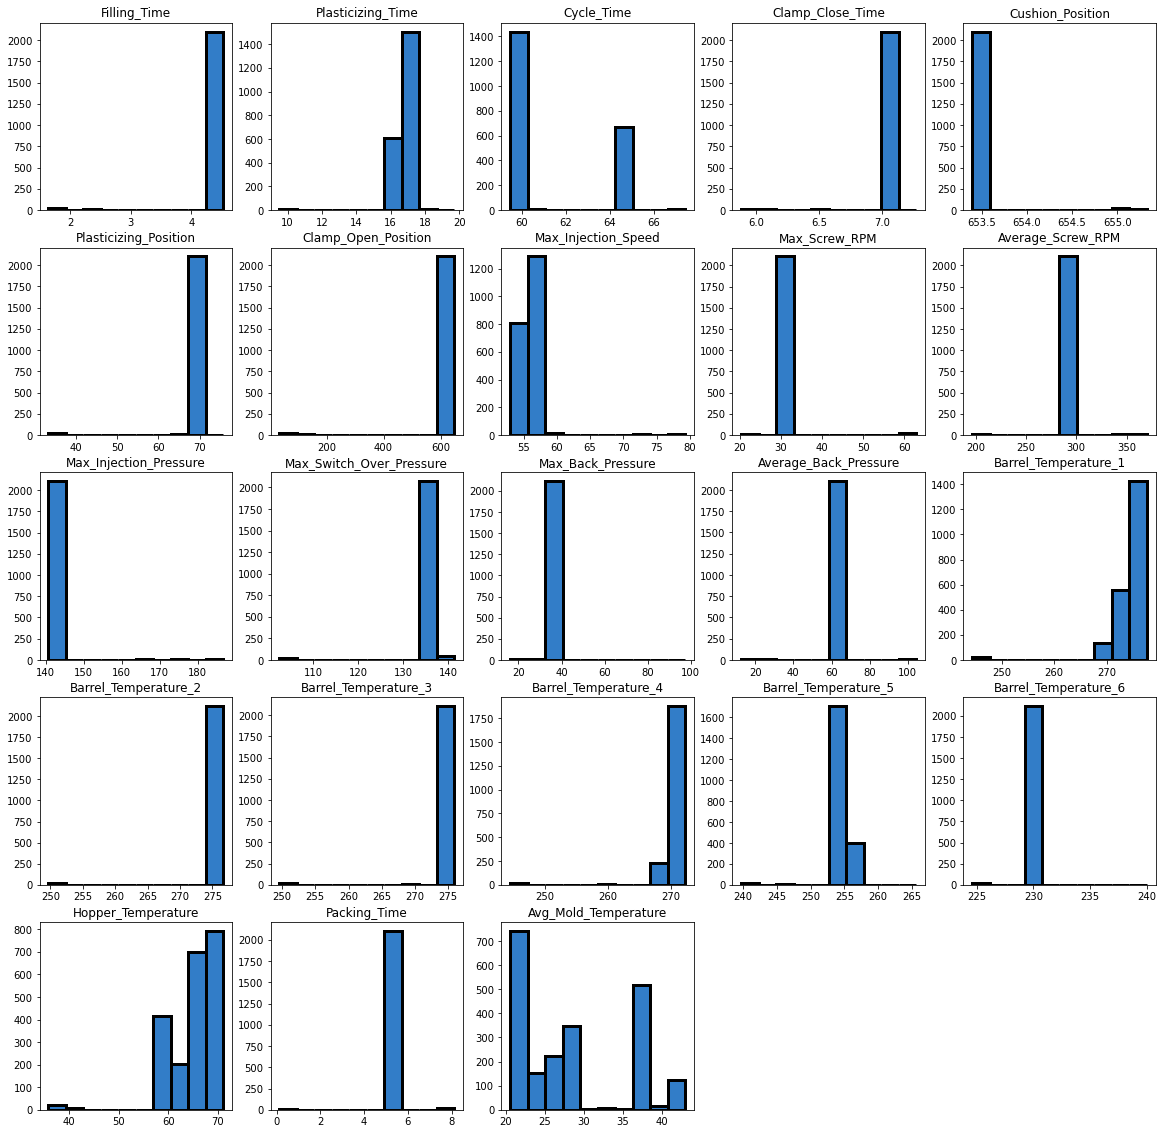

In [12]:
# unlabele데이터 히스토그램 시각화

data = unlabeled_CN7_650T_train
for index, value in enumerate(data):
    sub = plt.subplot(5, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

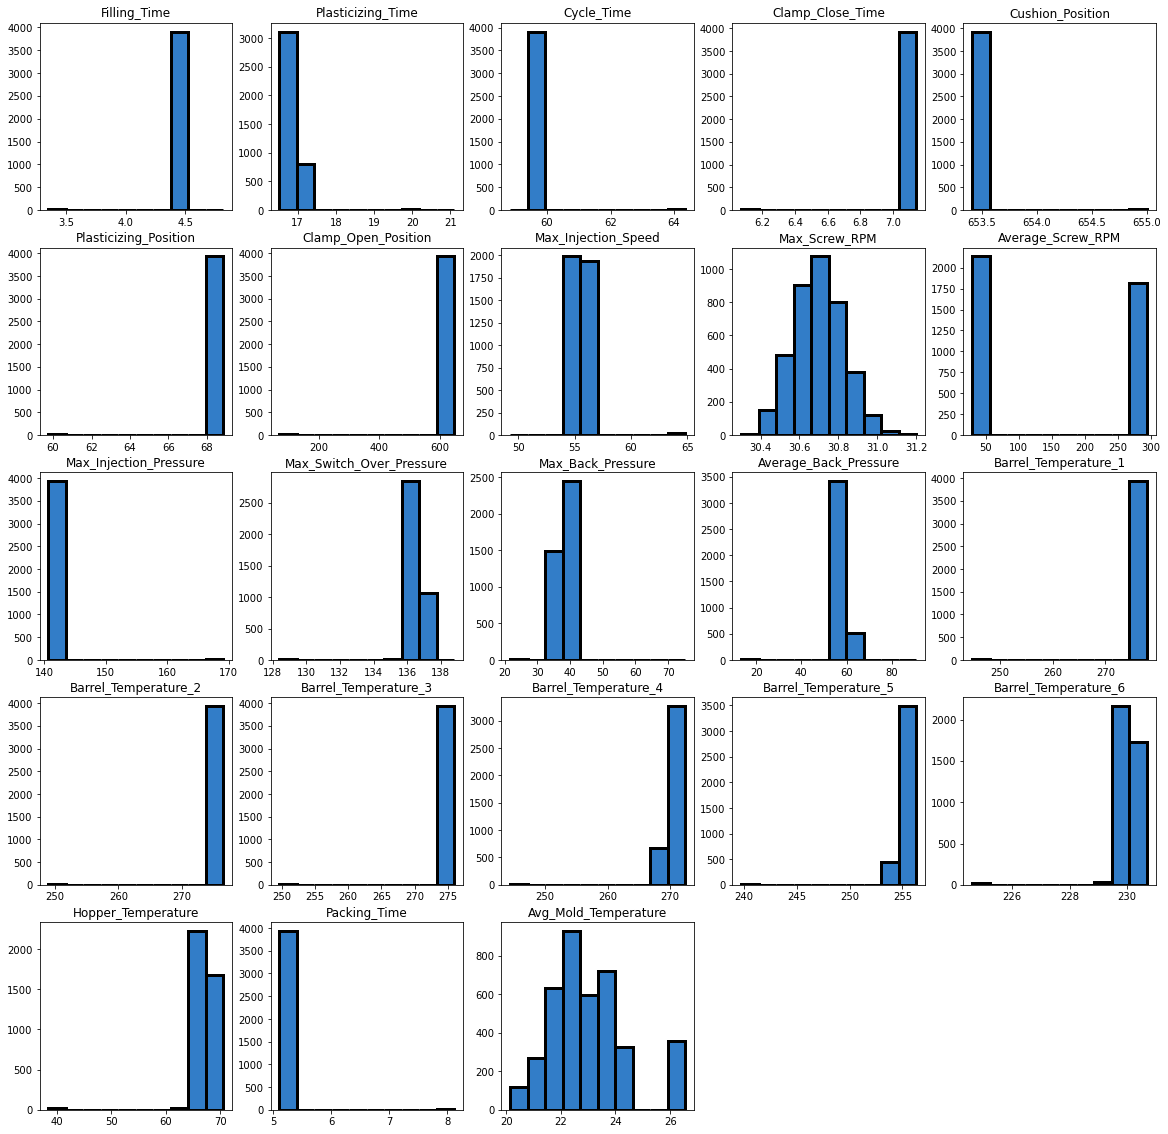

In [13]:
# labele데이터 히스토그램 시각화

data = labeled_df_Y
for index, value in enumerate(data):
    sub = plt.subplot(5, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

# DAE 적용

In [14]:
# label+unlabeled train 데이터
train_df = pd.concat([unlabeled_CN7_650T_train, labeled_df_Y], ignore_index=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6081 entries, 0 to 6080
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Filling_Time              6081 non-null   float64
 1   Plasticizing_Time         6081 non-null   float64
 2   Cycle_Time                6081 non-null   float64
 3   Clamp_Close_Time          6081 non-null   float64
 4   Cushion_Position          6081 non-null   float64
 5   Plasticizing_Position     6081 non-null   float64
 6   Clamp_Open_Position       6081 non-null   float64
 7   Max_Injection_Speed       6081 non-null   float64
 8   Max_Screw_RPM             6081 non-null   float64
 9   Average_Screw_RPM         6081 non-null   float64
 10  Max_Injection_Pressure    6081 non-null   float64
 11  Max_Switch_Over_Pressure  6081 non-null   float64
 12  Max_Back_Pressure         6081 non-null   float64
 13  Average_Back_Pressure     6081 non-null   float64
 14  Barrel_T

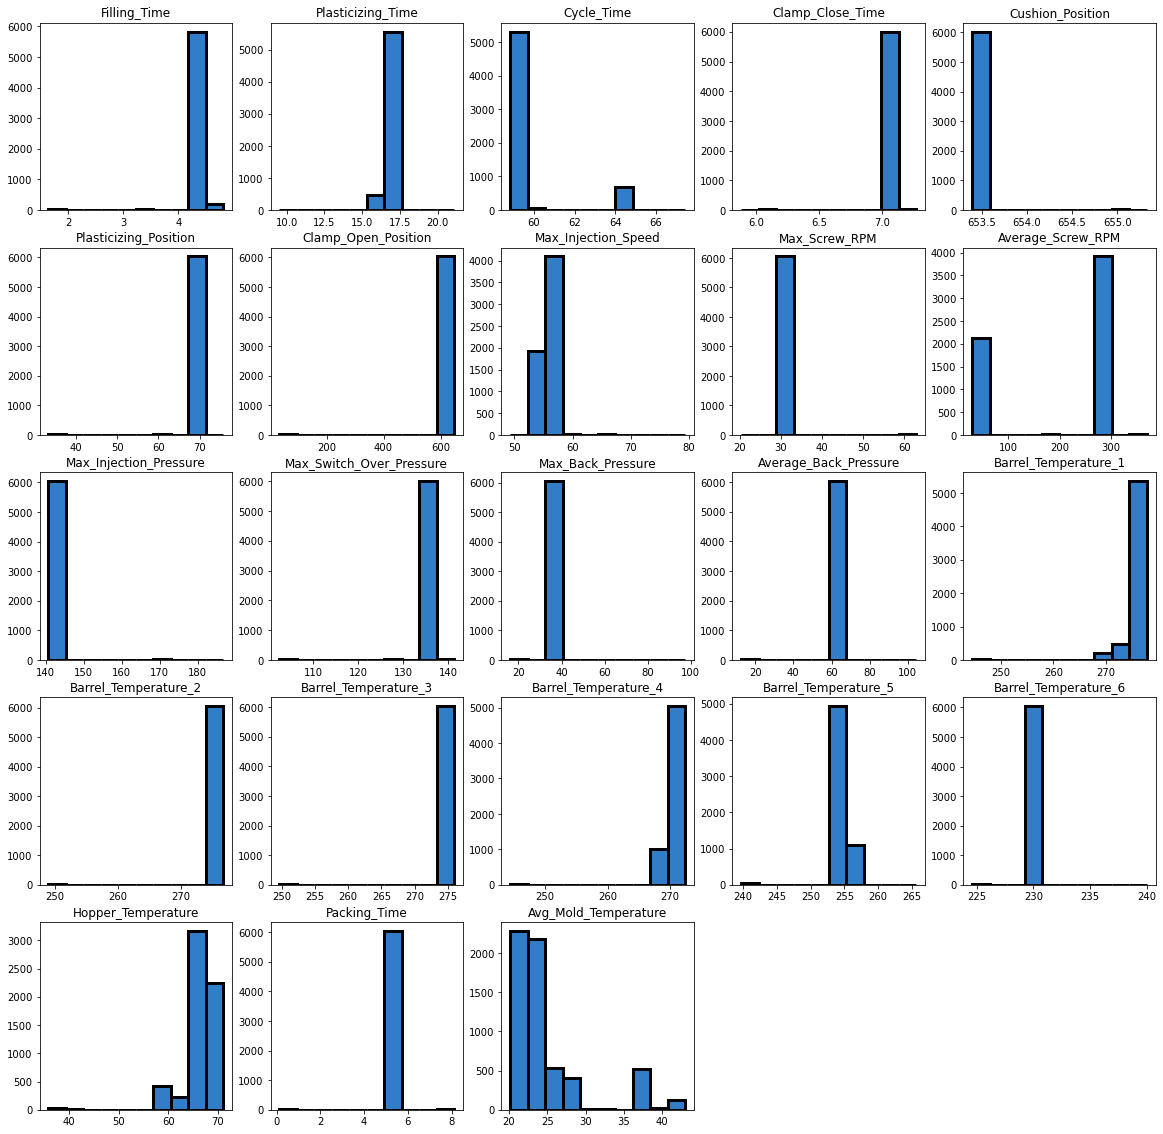

In [15]:
# train 데이터 히스토그램 시각화

data = train_df
for index, value in enumerate(data):
    sub = plt.subplot(5, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

In [16]:
train_df

,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,...,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Packing_Time,Avg_Mold_Temperature
0,4.46,16.470000,64.460000,7.11,653.390000,...,255.100000,230.000000,60.200000,5.11,38.10
1,4.47,16.470000,64.460000,7.09,653.390000,...,255.500000,230.000000,60.200000,5.12,37.95
2,4.46,16.500000,64.420000,7.10,653.390000,...,255.000000,230.000000,59.600000,5.12,37.95
3,4.46,16.470000,64.420000,7.10,653.390000,...,255.000000,230.100000,59.800000,5.12,37.70
4,4.49,16.450000,64.460000,7.10,653.390000,...,254.900000,230.300000,59.400000,5.12,37.80
...,...,...,...,...,...,...,...,...,...,...,...
6076,4.48,16.620001,59.560001,7.11,653.429993,...,255.600006,229.600006,66.099998,5.12,21.70
6077,4.48,16.650000,59.560001,7.11,653.429993,...,254.899994,230.000000,66.099998,5.12,21.70
6078,4.48,16.650000,59.560001,7.11,653.429993,...,254.899994,230.000000,66.099998,5.12,21.70
6079,4.48,16.629999,59.580002,7.11,653.429993,...,255.100006,230.199997,65.199997,5.12,21.65


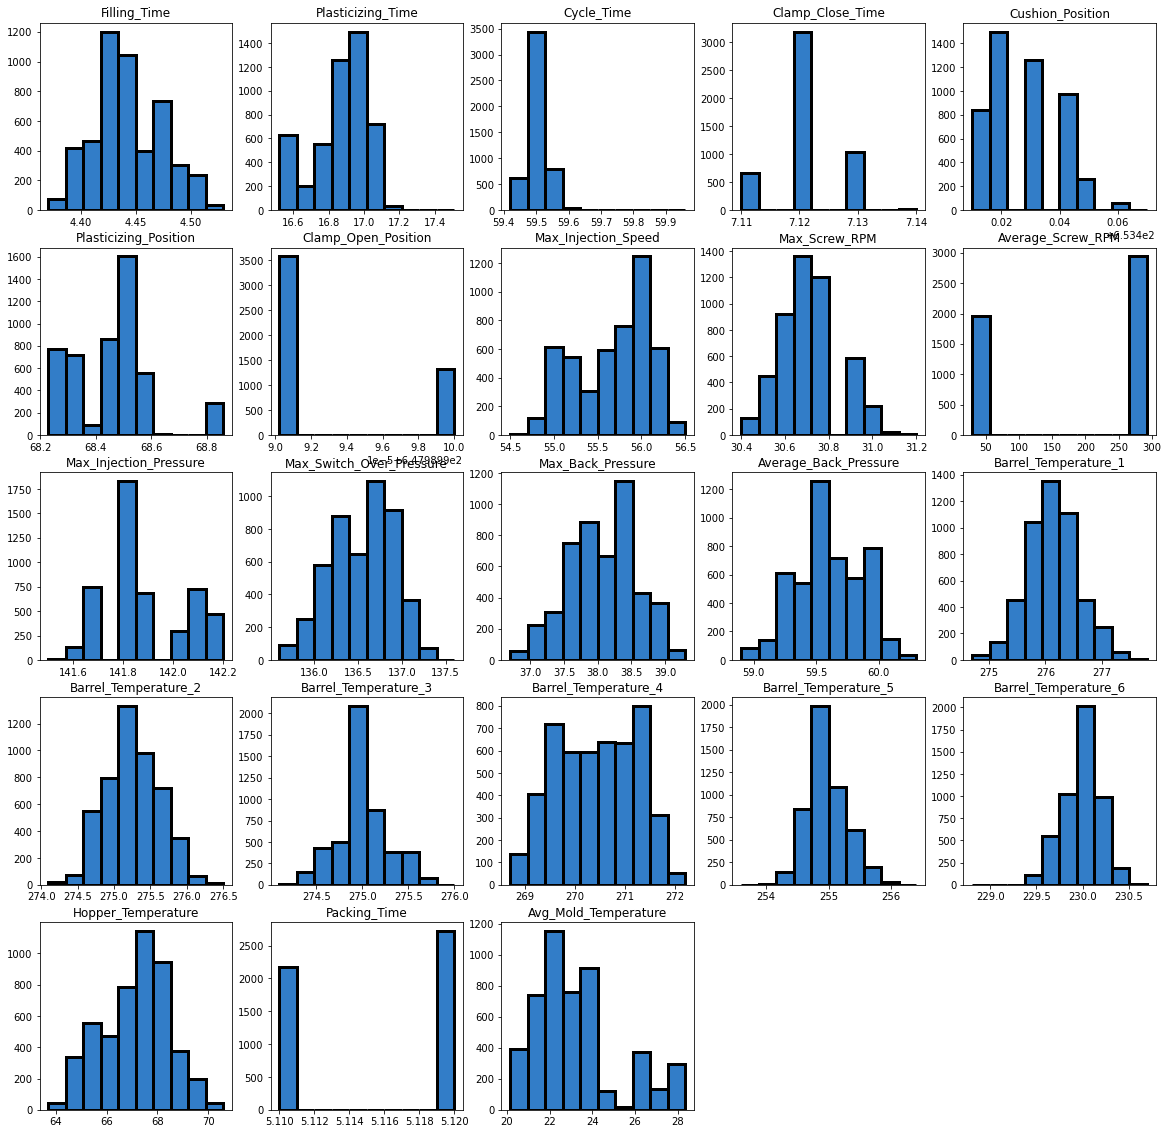

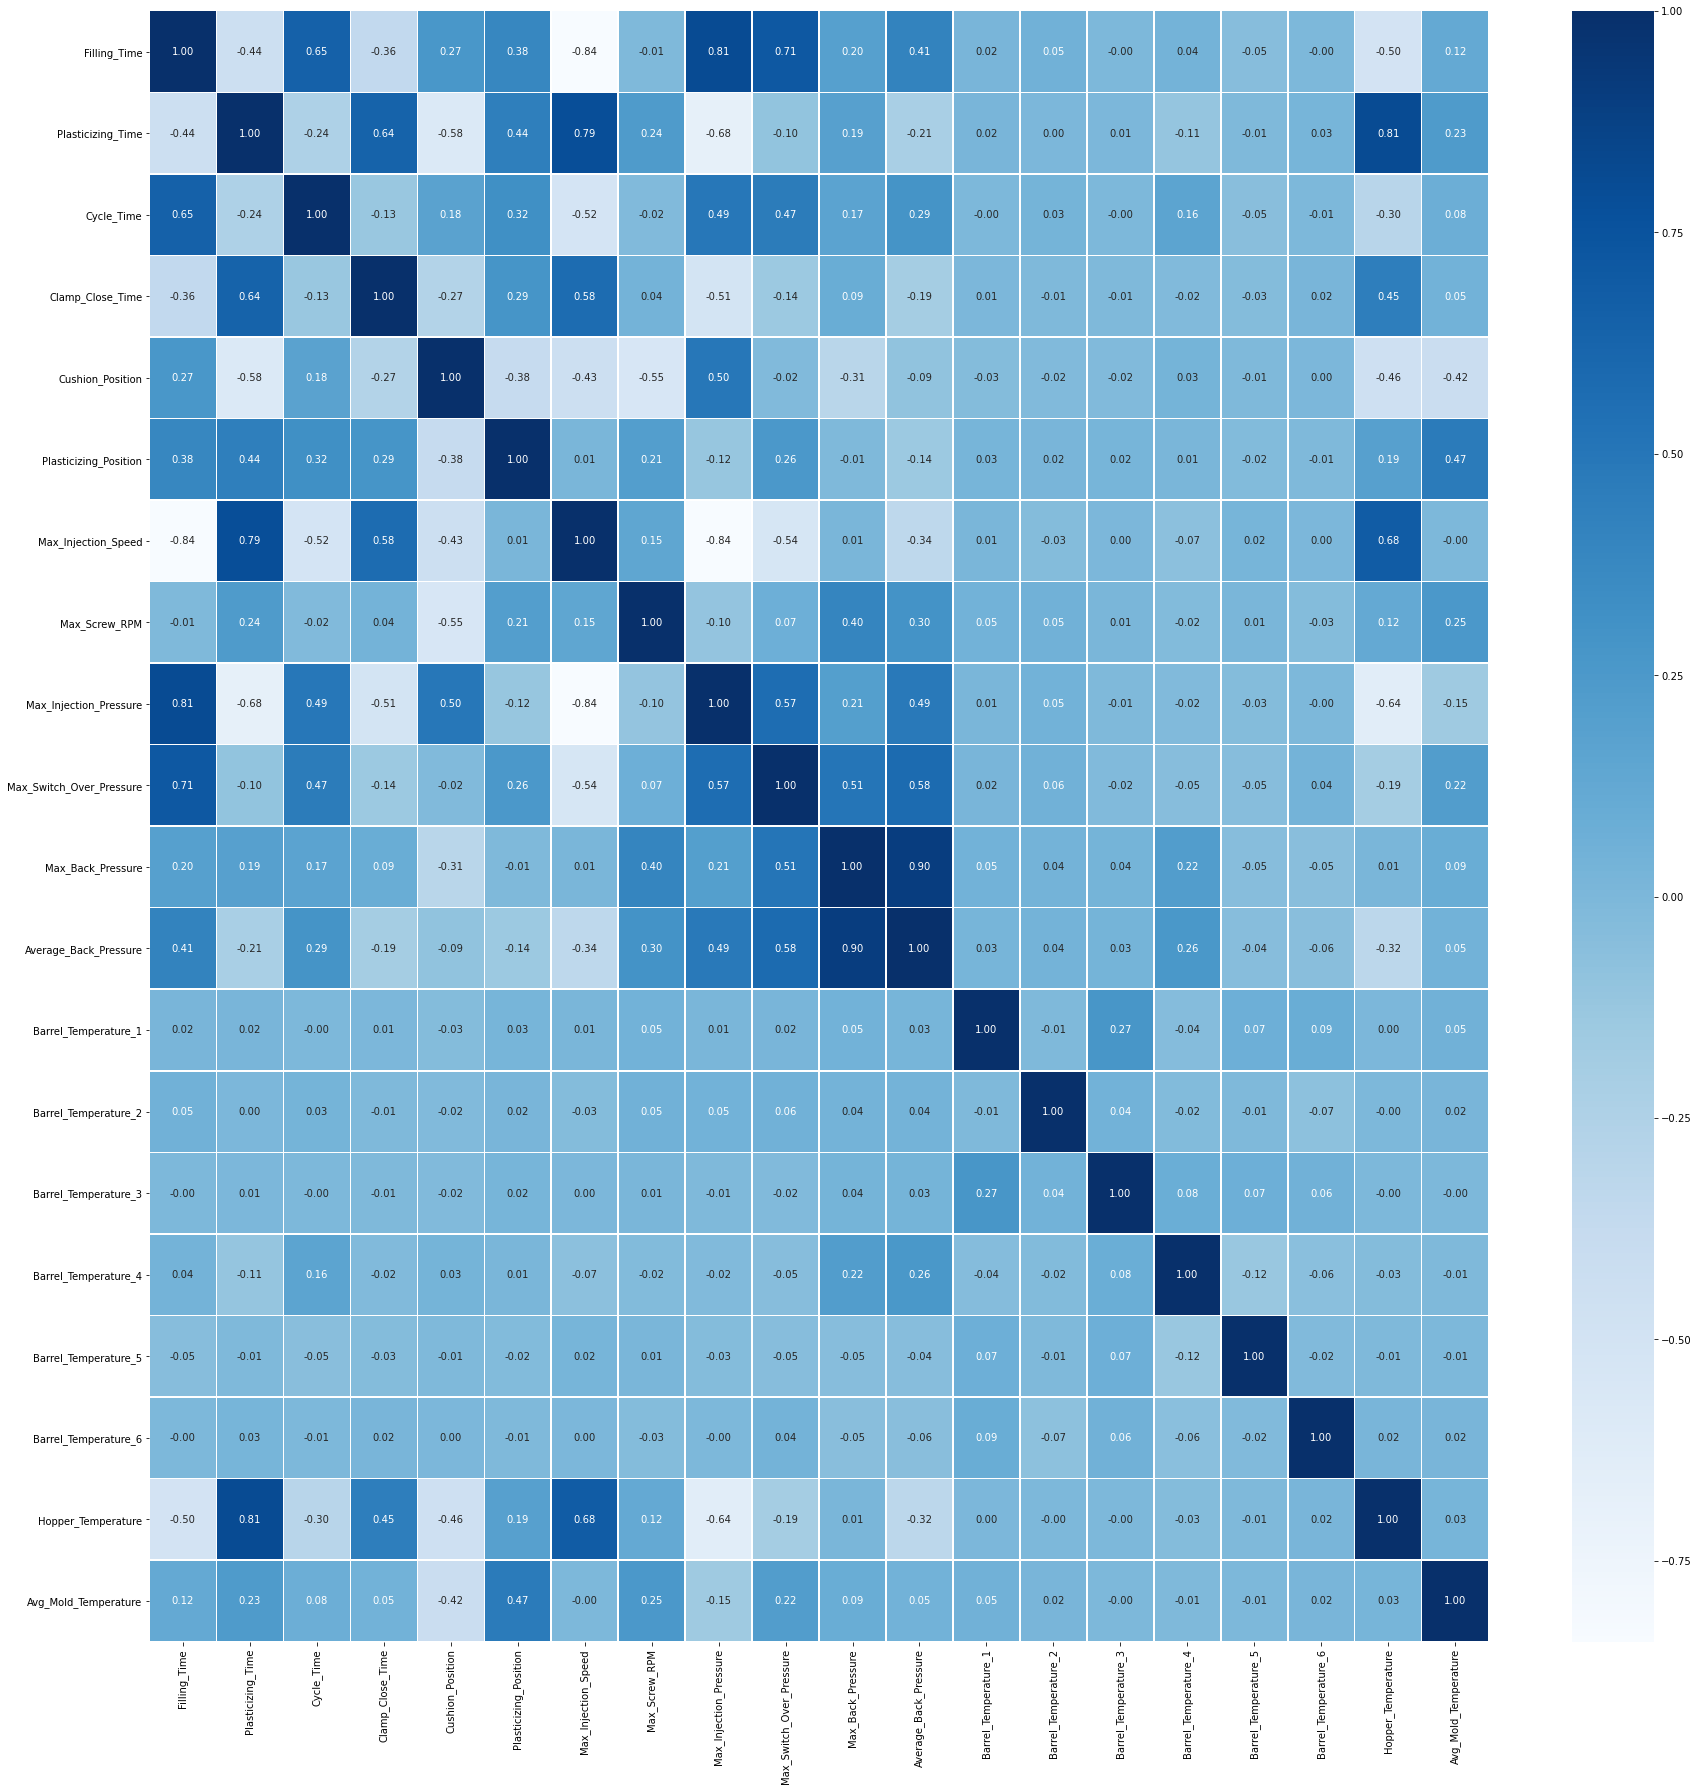

In [17]:
# outlier 제거
outlier_result = train_df.apply(outlier)
train_df = train_df[outlier_result.sum(axis=1) < 2]

data = train_df
for index, value in enumerate(data):
    sub = plt.subplot(5, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)
    
data = data.drop(["Clamp_Open_Position", "Average_Screw_RPM", "Packing_Time"], axis=1) 

# 상관관계 시각화
plt.figure(figsize=(30, 30))
sns.heatmap(data=data.corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')

# 데이터 정규화
scaler = preprocessing.MinMaxScaler()
train_df = scaler.fit_transform(train_df)
labeled_df_N_test = scaler.transform(labeled_df_N_test)

# 학습, 평가데이터 분리
train_df, test_df_Y = train_test_split(train_df, train_size=0.8, test_size=0.2)

In [18]:
unsc_train_df = scaler.inverse_transform(train_df)

unsc_test_df = scaler.inverse_transform(test_df_Y)

In [19]:
def denoising_autoencoder(data):
    data_input = Input((data.shape[1],))
    denoising = Dropout(0.3)(data_input)
    h1 = Dense(20)(data_input)
#     h1 = BatchNormalization()(h1)
    h1 = Activation('relu')(h1)
    h2 = Dense(10)(h1)
#     h2 = BatchNormalization()(h2)
    h2 = Activation('relu')(h2)
    h3 = Dense(5)(h2)
#     h3 = BatchNormalization()(h3)
    h3 = Activation('relu')(h3)
    h4 = Dense(10)(h3)
#     h4 = BatchNormalization()(h4)
    h4 = Activation('relu')(h4)
    h5 = Dense(20)(h4)
#     h5 = BatchNormalization()(h5)
    h5 = Activation('relu')(h5)
    h6 = Dense(data.shape[1])(h5)
#     h6 = BatchNormalization()(h6)
    out_put = Activation('relu')(h6)
    
    DAE = Model(data_input, out_put)
    DAE.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
    DAE.summary()
    return DAE
#     # Encoder
#     dropout_encoder = Sequential([Dropout(0.3), Dense(10, activation="relu"), Dense(5, activation="relu"), Dense(3, activation="relu")])
#     # Decoder
#     dropout_decoder = Sequential([Dense(5, activation="relu", input_shape=[3]), Dense(10, activation="relu", input_shape=[5]), Dense(data.shape[1], activation="relu")])
#     DAE = Sequential([dropout_encoder, dropout_decoder])
#     DAE.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

#     return DAE

In [21]:
# DAE 적용
DAE = denoising_autoencoder(train_df)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 23)]              0         
_________________________________________________________________
dense (Dense)                (None, 20)                480       
_________________________________________________________________
activation (Activation)      (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
activation_2 (Activation)    (None, 5)                 0     

In [22]:
# 모델 훈련
history = DAE.fit(train_df, train_df, batch_size=10, epochs=50, validation_split=0.2, callbacks=[EarlyStopping(monitor="val_loss", patience=7, mode="min")])

Epoch 1/50
314/314 [==============================] - 4s 5ms/step - loss: 0.1786 - accuracy: 0.0112 - val_loss: 0.1235 - val_accuracy: 0.0204
Epoch 2/50
314/314 [==============================] - 2s 5ms/step - loss: 0.1111 - accuracy: 0.0176 - val_loss: 0.1037 - val_accuracy: 0.0217
Epoch 3/50
314/314 [==============================] - 2s 5ms/step - loss: 0.1037 - accuracy: 0.0789 - val_loss: 0.1008 - val_accuracy: 0.1582
Epoch 4/50
314/314 [==============================] - 2s 5ms/step - loss: 0.1012 - accuracy: 0.1960 - val_loss: 0.0983 - val_accuracy: 0.2066
Epoch 5/50
314/314 [==============================] - 2s 5ms/step - loss: 0.0988 - accuracy: 0.2123 - val_loss: 0.0959 - val_accuracy: 0.2054
Epoch 6/50
314/314 [==============================] - 2s 5ms/step - loss: 0.0960 - accuracy: 0.2069 - val_loss: 0.0926 - val_accuracy: 0.1990
Epoch 7/50
314/314 [==============================] - 2s 5ms/step - loss: 0.0851 - accuracy: 0.1871 - val_loss: 0.0791 - val_accuracy: 0.1977
Epoch 

In [23]:
# 훈련격과 시각화 함수
def training_visualize(model_his):
    sub = plt.subplot(2, 1, 1)
    # 훈련 결과 시각화
    sub.plot(model_his.history["loss"], label="Training Loss")
    sub.plot(model_his.history["val_loss"], label="Validation Loss")
    sub.legend()
    sub = plt.subplot(2, 1, 2)
    sub.plot(model_his.history["accuracy"], label="Training Acc")
    sub.plot(model_his.history["val_accuracy"], label="Validation Acc")
    sub.legend()

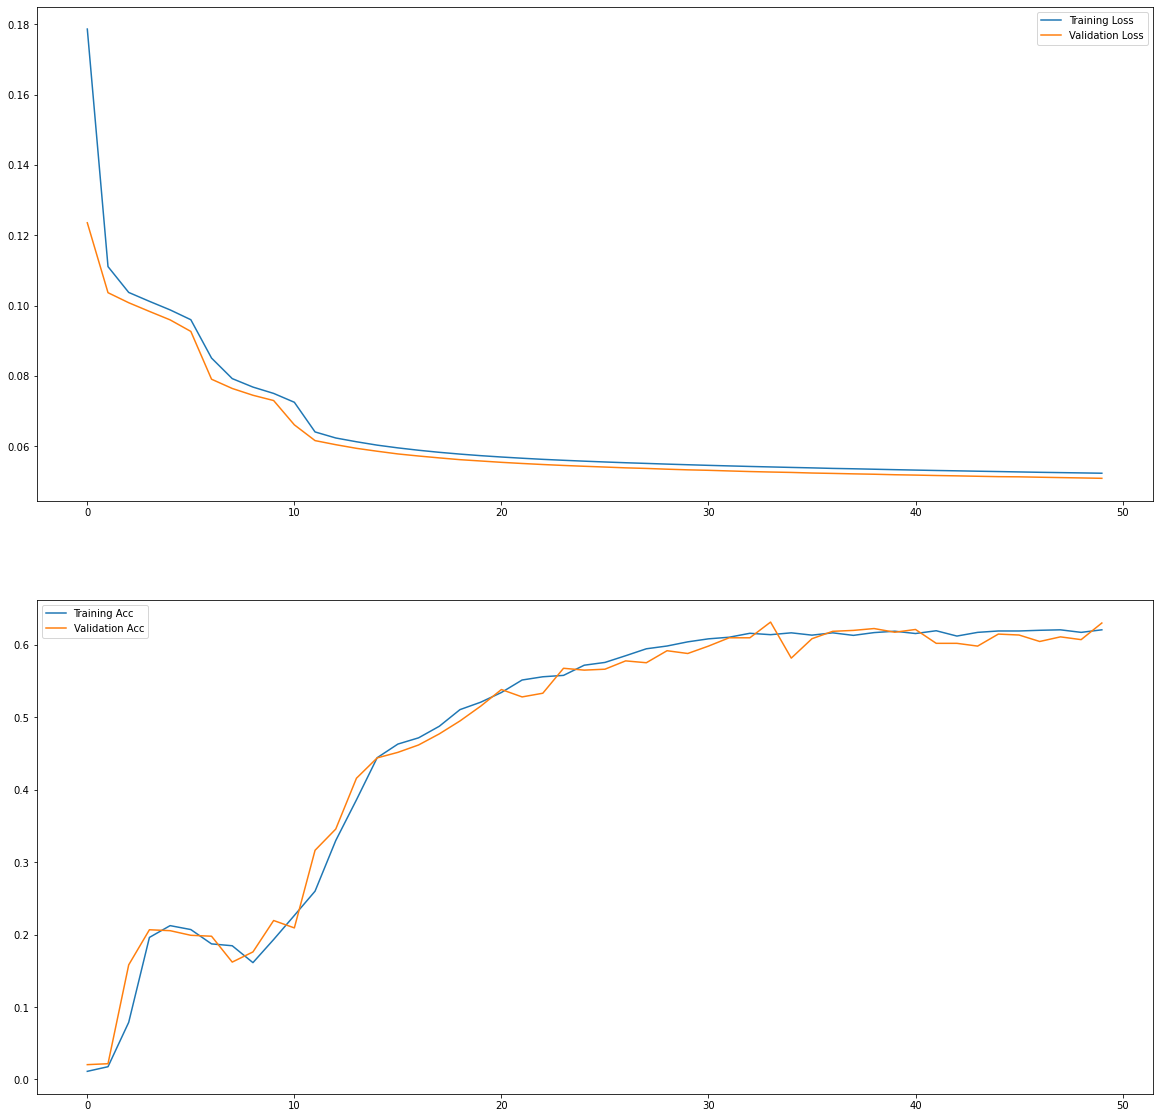

In [24]:
# 데이터 별 훈련결과 시각화
training_visualize(history)

In [25]:
def defective_decision(DAE, train_data, test_data):
    # 학습 데이터 예측값
    pred = DAE.predict(train_data)
    # 학습 데이터 복원 오차
    train_loss = np.mean(np.square(pred-train_data), axis=1)
    #임계치 (3시그마-99.7%)
    threshold = np.mean(train_loss) + 3*np.std(train_loss)

    # 평가 데이터
    # 예측값
    pred_def = DAE.predict(test_data)
    # 복원오차
    test_loss = np.mean(np.square(pred_def - test_data), axis=1)
    
    # colunm별 절대 오차
    colunm_error = np.abs(pred_def - test_data)

    defect = test_loss > threshold
    print("불량 개수: ", np.sum(defect))
    
    return defect, colunm_error

In [26]:
# 확인
print(f"테스트 데이터 개수: {len(test_df_Y)}")
test_Y_defect, Y_CE = defective_decision(DAE, train_df, test_df_Y)

테스트 데이터 개수: 980
불량 개수:  13


In [27]:
# 확인
print(f"테스트 데이터 개수: {len(labeled_df_N_test)}")
test_N_defect, N_CE = defective_decision(DAE, train_df, labeled_df_N_test)

테스트 데이터 개수: 28
불량 개수:  16


In [28]:
true_val = np.concatenate([np.zeros(len(test_Y_defect)), np.ones(len(test_N_defect))])
predict_val = np.concatenate([test_Y_defect, test_N_defect])

In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
confusion_matrix(true_val, predict_val)

array([[967,  13],
       [ 12,  16]], dtype=int64)

In [30]:
print("정확도: ", accuracy_score(true_val, predict_val))
print("정밀도: ", precision_score(true_val, predict_val))
print("재현율: ", recall_score(true_val, predict_val))
print("F1: ", f1_score(true_val, predict_val))

정확도:  0.9751984126984127
정밀도:  0.5517241379310345
재현율:  0.5714285714285714
F1:  0.5614035087719299


In [31]:
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
#(latent_vector 시각화)

encoder = Model(inputs = input_img, outputs=encoder2)

latent_vector = encoder.predict(x_test)

rcParams['figure.figsize'] = 10, 8
fig = plt.figure(1)
ax = Axes3D(fig)

xs = latent_vector[:, 0]
ys = latent_vector[:, 1]
zs = latent_vector[:, 2]

color = ['red', 'green', 'blue', 'lime', 'white', 'pink', 'aqua', 'violet', 'gold', 'coral']

for x, y, z, label in zip(xs, ys, zs, y_test):
  c=color[int(label)]
  ax.text(x,y,z,label, backgroundcolor=c)

ax.set_xlim(xs.min(), xs.max())
ax.set_ylim(ys.min(), ys.max())
ax.set_zlim(zs.min(), zs.max())

plt.show()

NameError: name 'input_img' is not defined

In [32]:
# CN7_우진650톤 데이터 추출
CN7_filter = unlabeled_df["PART_NAME"].str.contains("CN7")
Eq650_filter = unlabeled_df["EQUIP_NAME"].str.contains("650")
CN7_650T_df = unlabeled_df[CN7_filter & Eq650_filter]
CN7_650T_1st_refine = CN7_650T_df.drop(["PART_FACT_SERIAL", "PART_NO", "PART_NAME", "EQUIP_CD", "EQUIP_NAME"], axis=1)
# 잡음제거 오토인코더는 정상데이터로 학습시키므로 ERR기준으로 데이터 분리
CN7_650T_1st_refine = CN7_650T_1st_refine[CN7_650T_1st_refine["ERR_FACT_QTY"] <= 0]
# CN7_650T_1st_refine.drop("ERR_FACT_QTY", axis=1, inplace=True)
# 학습을 위해 Time데이터 제거
CN7_650T_1st_refine.drop("TimeStamp", axis=1, inplace=True)

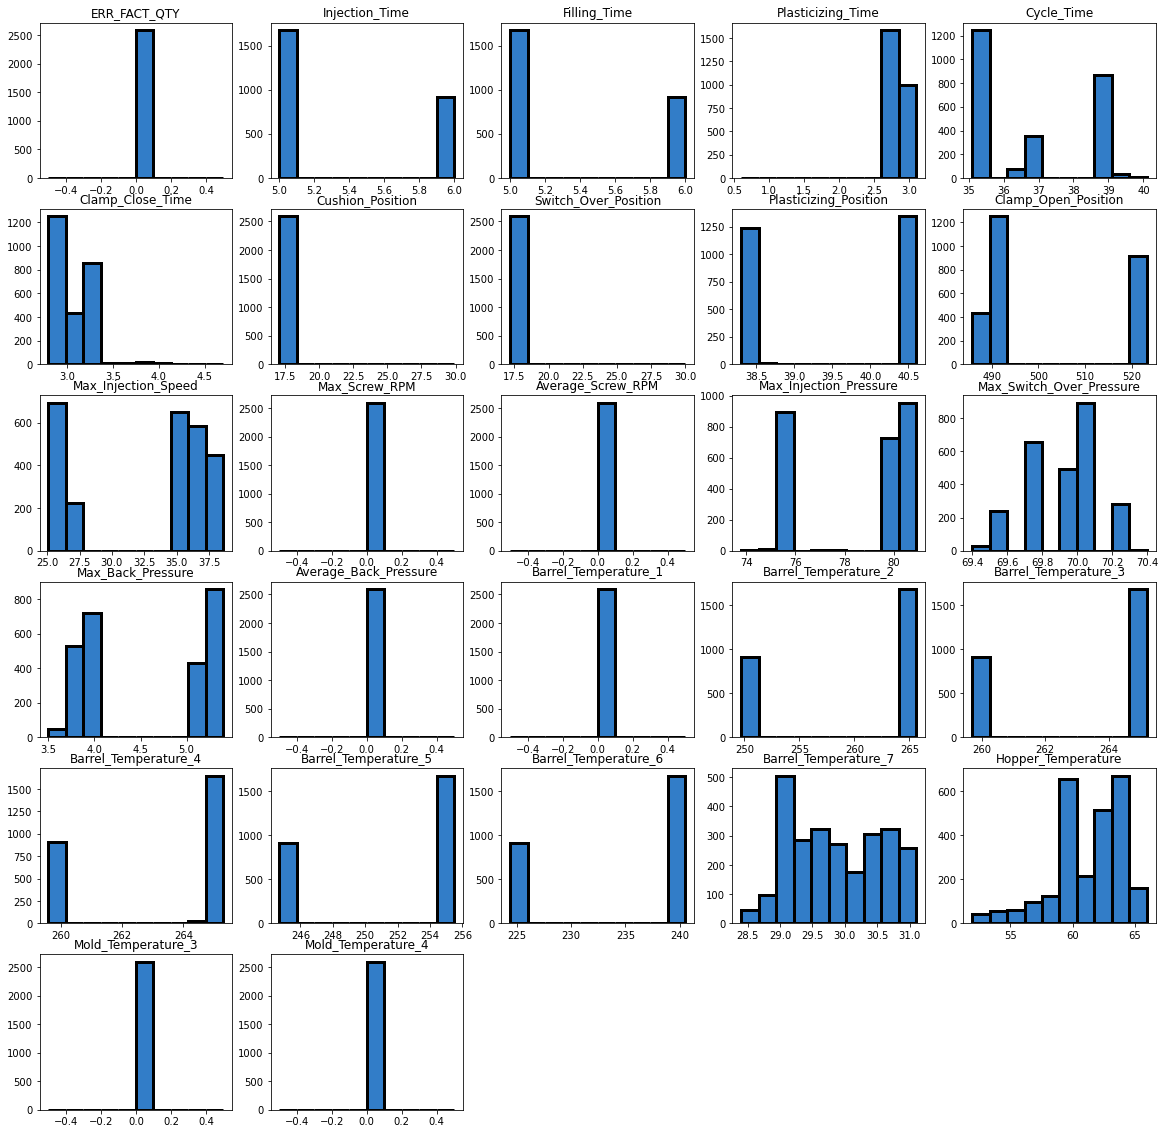

In [33]:
# 히스토그램 시각화
# CN7_650T_1st_refine - 나누기 전
# CN7_650T_LH, CN7_650T_RH
# CN7_650T_1st_refine[CN7_650T_1st_refine["Plasticizing_Time"] < 5]
# CN7_650T_1st_refine.drop["Max_Screw_RPM","Average_Screw_RPM", axis=1]
# CN7_650T_1st_refine[CN7_650T_1st_refine["ERR_FACT_QTY"] < 5]
# CN7_650T_1st_refine[CN7_650T_1st_refine["Max_Injection_Pressure"] < 100]
## CN7_650T_1st_refine[CN7_650T_1st_refine["Max_Injection_Pressure"] > 100]

data = CN7_650T_1st_refine[CN7_650T_1st_refine["Switch_Over_Position"] != 0]
for index, value in enumerate(data):
    sub = plt.subplot(6, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

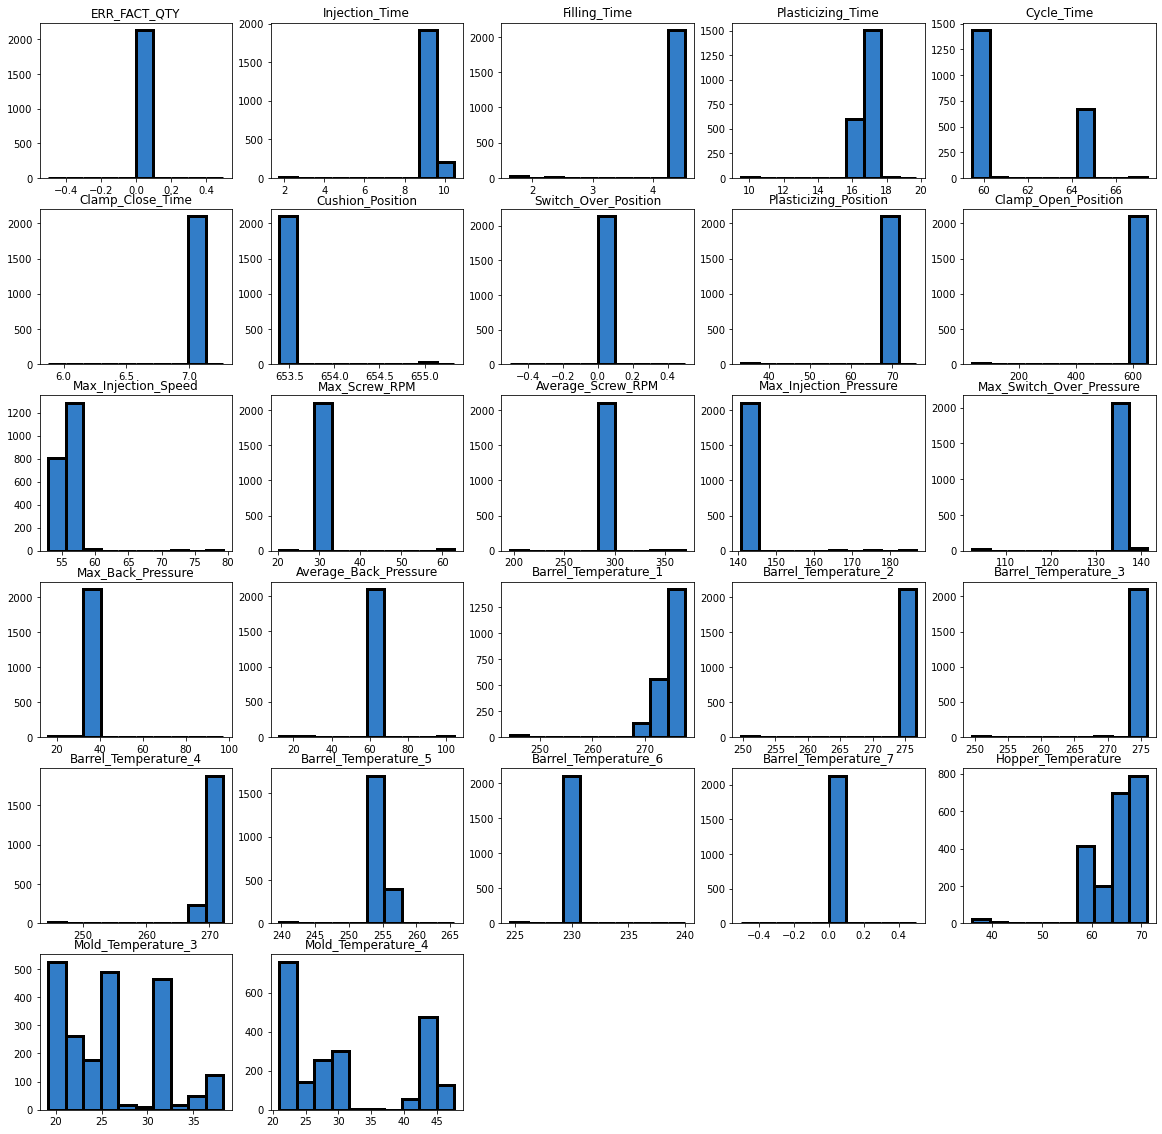

In [34]:
# 히스토그램 시각화
# CN7_650T_1st_refine - 나누기 전
# CN7_650T_LH, CN7_650T_RH
# CN7_650T_1st_refine[CN7_650T_1st_refine["Plasticizing_Time"] < 5]
# CN7_650T_1st_refine.drop["Max_Screw_RPM","Average_Screw_RPM", axis=1]
# CN7_650T_1st_refine[CN7_650T_1st_refine["ERR_FACT_QTY"] < 5]
# CN7_650T_1st_refine[CN7_650T_1st_refine["Max_Injection_Pressure"] < 100]
## CN7_650T_1st_refine[CN7_650T_1st_refine["Max_Injection_Pressure"] > 100]

data = CN7_650T_1st_refine[CN7_650T_1st_refine["Switch_Over_Position"] == 0]
for index, value in enumerate(data):
    sub = plt.subplot(6, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

In [35]:
# 히스토그램 시각화
# test_df - 나누기 전

data = test_df[test_df["Switch_Over_Position"] == 0]
for index, value in enumerate(data):
    sub = plt.subplot(6, 5, index+1)
    sub.hist(data[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

NameError: name 'test_df' is not defined

In [114]:
# 상관관계 시각화
plt.figure(figsize=(30, 30))
sns.heatmap(data=CN7_650T_1st_refine[CN7_650T_1st_refine["PART_TYPE"].isin([1])].corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')

# 히스토그램 시각화
visual_CN7_650T_1st_refine = CN7_650T_1st_refine.drop("TimeStamp", axis=1)
for index, value in enumerate(visual_CN7_650T_1st_refine):
    sub = plt.subplot(6, 5, index+1)
    sub.hist(visual_CN7_650T_1st_refine[value], facecolor=(50/255, 125/255, 200/255), linewidth=3, edgecolor='black')
    plt.title(value)

KeyError: 'PART_TYPE'

<Figure size 2160x2160 with 0 Axes>

In [115]:
# 비선형 regression

In [116]:
xlist=[unsc_test_df[:,0],unsc_test_df[:,1],unsc_test_df[:,2],unsc_test_df[:,3],
       unsc_test_df[:,4],unsc_test_df[:,5],unsc_test_df[:,6],unsc_test_df[:,7],
      unsc_test_df[:,8],unsc_test_df[:,9],unsc_test_df[:,10],unsc_test_df[:,1],
      unsc_test_df[:,12]]

In [117]:
elist=[Y_CE[:,0],Y_CE[:,1],Y_CE[:,2],Y_CE[:,3],Y_CE[:,4],Y_CE[:,5],Y_CE[:,6],
      Y_CE[:,7],Y_CE[:,8],Y_CE[:,9],Y_CE[:,10],Y_CE[:,11],Y_CE[:,12]]

In [140]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline   

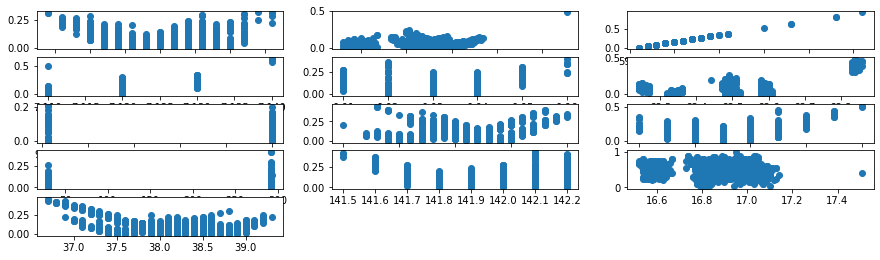

In [149]:
fig = plt.figure(figsize=(15, 5))

def scatter():
    i=0
    while i < 13:
        plt.subplot(6,3,i+1)
        plt.scatter(xlist[i],elist[i])
        i=i+1
    return
scatter()

In [150]:
def reg():
    i=0
    global reg_list
    reg_list=[]
    poly_features = PolynomialFeatures(degree=2, include_bias=False)
    while i < 13:
        x=xlist[i].reshape(-1,1)
        y=elist[i].reshape(-1,1)
        x_poly = poly_features.fit_transform(x)
        #print(x[0], x_poly[0])
        reg_list.append(x[0])
        i=i+1
    return reg_list

reg()

[array([4.42000008]),
 array([16.78000069]),
 array([59.45999908]),
 array([7.11999989]),
 array([653.44000244]),
 array([68.26000214]),
 array([647.98999023]),
 array([55.70000076]),
 array([30.89999962]),
 array([29.20000076]),
 array([141.8999939]),
 array([16.78000069]),
 array([37.70000076])]

<Figure size 1080x360 with 0 Axes>

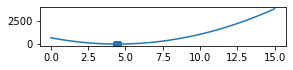

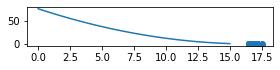

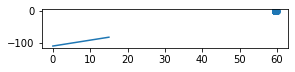

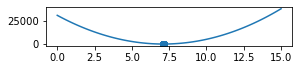

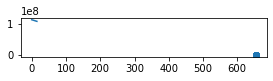

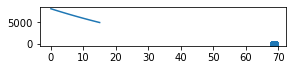

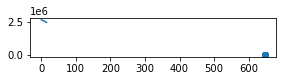

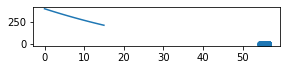

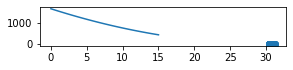

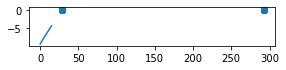

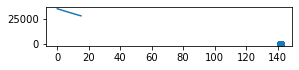

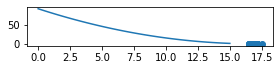

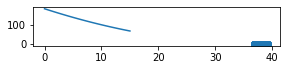

In [159]:
# 다항회귀 그래프
def reg_plt():
    i=0
    fig = plt.figure(figsize=(15, 5))
    model_lr = make_pipeline(PolynomialFeatures(degree=2, include_bias=False),
                         LinearRegression())
    while i < 13:
        x=xlist[i].reshape(-1,1)
        y=elist[i].reshape(-1,1)
        xx = np.linspace(0, 15,100)
        model_lr.fit(x, y)
        #print(model_lr.steps[1][1].coef_) 
        y_pred = model_lr.predict(xx[:, np.newaxis])
        fig = plt.figure(figsize=(15, 5))
        plt.subplot(6,3,i+1)
        plt.plot(xx, y_pred)
        plt.scatter(x,y)
        i=i+1
    return
reg_plt()

In [60]:
#간단한 딥러닝 예측

In [61]:
import tensorflow as tf

In [63]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(20, input_dim = 1 ,activation='swish'),
        tf.keras.layers.Dense(20, activation='swish'),
        tf.keras.layers.Dense(20, activation='swish'),
        tf.keras.layers.Dense(1)
    ])

In [64]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [65]:
history = model.fit(x,y, epochs=500, verbose=2)

Epoch 1/500
31/31 - 0s - loss: 0.0051
Epoch 2/500
31/31 - 0s - loss: 0.0045
Epoch 3/500
31/31 - 0s - loss: 0.0047
Epoch 4/500
31/31 - 0s - loss: 0.0045
Epoch 5/500
31/31 - 0s - loss: 0.0045
Epoch 6/500
31/31 - 0s - loss: 0.0046
Epoch 7/500
31/31 - 0s - loss: 0.0049
Epoch 8/500
31/31 - 0s - loss: 0.0047
Epoch 9/500
31/31 - 0s - loss: 0.0045
Epoch 10/500
31/31 - 0s - loss: 0.0045
Epoch 11/500
31/31 - 0s - loss: 0.0046
Epoch 12/500
31/31 - 0s - loss: 0.0045
Epoch 13/500
31/31 - 0s - loss: 0.0046
Epoch 14/500
31/31 - 0s - loss: 0.0050
Epoch 15/500
31/31 - 0s - loss: 0.0045
Epoch 16/500
31/31 - 0s - loss: 0.0046
Epoch 17/500
31/31 - 0s - loss: 0.0045
Epoch 18/500
31/31 - 0s - loss: 0.0045
Epoch 19/500
31/31 - 0s - loss: 0.0046
Epoch 20/500
31/31 - 0s - loss: 0.0047
Epoch 21/500
31/31 - 0s - loss: 0.0046
Epoch 22/500
31/31 - 0s - loss: 0.0045
Epoch 23/500
31/31 - 0s - loss: 0.0045
Epoch 24/500
31/31 - 0s - loss: 0.0045
Epoch 25/500
31/31 - 0s - loss: 0.0045
Epoch 26/500
31/31 - 0s - loss: 0.

Epoch 209/500
31/31 - 0s - loss: 0.0045
Epoch 210/500
31/31 - 0s - loss: 0.0045
Epoch 211/500
31/31 - 0s - loss: 0.0045
Epoch 212/500
31/31 - 0s - loss: 0.0046
Epoch 213/500
31/31 - 0s - loss: 0.0045
Epoch 214/500
31/31 - 0s - loss: 0.0045
Epoch 215/500
31/31 - 0s - loss: 0.0045
Epoch 216/500
31/31 - 0s - loss: 0.0045
Epoch 217/500
31/31 - 0s - loss: 0.0045
Epoch 218/500
31/31 - 0s - loss: 0.0044
Epoch 219/500
31/31 - 0s - loss: 0.0045
Epoch 220/500
31/31 - 0s - loss: 0.0045
Epoch 221/500
31/31 - 0s - loss: 0.0045
Epoch 222/500
31/31 - 0s - loss: 0.0045
Epoch 223/500
31/31 - 0s - loss: 0.0045
Epoch 224/500
31/31 - 0s - loss: 0.0045
Epoch 225/500
31/31 - 0s - loss: 0.0044
Epoch 226/500
31/31 - 0s - loss: 0.0045
Epoch 227/500
31/31 - 0s - loss: 0.0045
Epoch 228/500
31/31 - 0s - loss: 0.0044
Epoch 229/500
31/31 - 0s - loss: 0.0045
Epoch 230/500
31/31 - 0s - loss: 0.0045
Epoch 231/500
31/31 - 0s - loss: 0.0045
Epoch 232/500
31/31 - 0s - loss: 0.0045
Epoch 233/500
31/31 - 0s - loss: 0.0045


Epoch 414/500
31/31 - 0s - loss: 0.0044
Epoch 415/500
31/31 - 0s - loss: 0.0045
Epoch 416/500
31/31 - 0s - loss: 0.0044
Epoch 417/500
31/31 - 0s - loss: 0.0045
Epoch 418/500
31/31 - 0s - loss: 0.0045
Epoch 419/500
31/31 - 0s - loss: 0.0045
Epoch 420/500
31/31 - 0s - loss: 0.0045
Epoch 421/500
31/31 - 0s - loss: 0.0045
Epoch 422/500
31/31 - 0s - loss: 0.0044
Epoch 423/500
31/31 - 0s - loss: 0.0045
Epoch 424/500
31/31 - 0s - loss: 0.0044
Epoch 425/500
31/31 - 0s - loss: 0.0045
Epoch 426/500
31/31 - 0s - loss: 0.0045
Epoch 427/500
31/31 - 0s - loss: 0.0045
Epoch 428/500
31/31 - 0s - loss: 0.0044
Epoch 429/500
31/31 - 0s - loss: 0.0045
Epoch 430/500
31/31 - 0s - loss: 0.0045
Epoch 431/500
31/31 - 0s - loss: 0.0044
Epoch 432/500
31/31 - 0s - loss: 0.0044
Epoch 433/500
31/31 - 0s - loss: 0.0045
Epoch 434/500
31/31 - 0s - loss: 0.0045
Epoch 435/500
31/31 - 0s - loss: 0.0045
Epoch 436/500
31/31 - 0s - loss: 0.0045
Epoch 437/500
31/31 - 0s - loss: 0.0045
Epoch 438/500
31/31 - 0s - loss: 0.0044


In [66]:
predictions = model.predict(x)

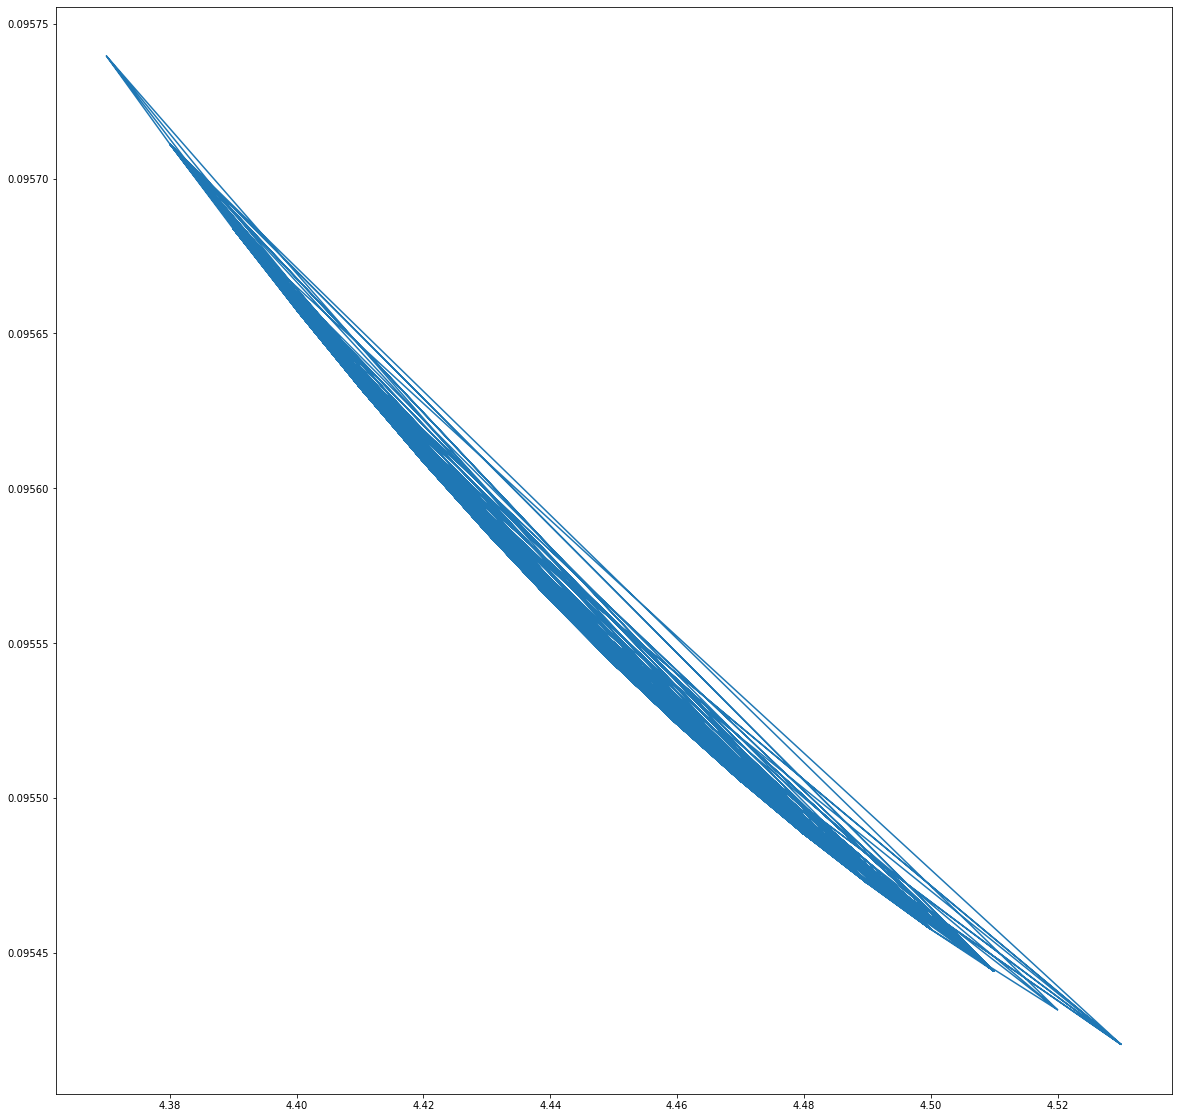

In [67]:
plt.plot(x,predictions)

In [68]:
#간단한 mlp 비선형 회귀

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt

In [70]:
num_data = len(x)

In [71]:
x = torch.Tensor(x).reshape(-1,1)
y = torch.Tensor(y).reshape(-1,1)
noise = init.normal_(torch.FloatTensor(num_data),1,std=30)

In [72]:
x.shape

torch.Size([980, 1])

In [73]:
model = nn.Sequential(
    nn.Linear(1,3),
    nn.LeakyReLU(0.2),
    nn.Linear(3,587),
    nn.LeakyReLU(0.2),
    nn.Linear(587,3),
    nn.LeakyReLU(0.2),    
    nn.Linear(3,1),
)

In [74]:
gpu = torch.device('cuda')
loss_func = nn.L1Loss().to(gpu)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
model = model.to(gpu)
x = x.to(gpu)
y = y.to(gpu)
num_epoch = 20000
loss_array = []
for epoch in range(num_epoch):
    optimizer.zero_grad()
    output = model(x)
    
    loss = loss_func(output,y)
    loss.backward()
    optimizer.step()
    
    loss_array.append(loss)
    if epoch % 100 == 0:
        print('epoch:', epoch, ' loss:', loss.item())

epoch: 0  loss: 0.14251738786697388
epoch: 100  loss: 0.05294542387127876
epoch: 200  loss: 0.052942149341106415
epoch: 300  loss: 0.05293778330087662
epoch: 400  loss: 0.05293235555291176
epoch: 500  loss: 0.052927687764167786
epoch: 600  loss: 0.05291849002242088
epoch: 700  loss: 0.052913110703229904
epoch: 800  loss: 0.05290699005126953
epoch: 900  loss: 0.05289675295352936
epoch: 1000  loss: 0.05288804695010185
epoch: 1100  loss: 0.052877120673656464
epoch: 1200  loss: 0.0528651624917984
epoch: 1300  loss: 0.05285041034221649
epoch: 1400  loss: 0.05283278971910477
epoch: 1500  loss: 0.05281459167599678
epoch: 1600  loss: 0.0527997761964798
epoch: 1700  loss: 0.05280609801411629
epoch: 1800  loss: 0.052780404686927795
epoch: 1900  loss: 0.05276310071349144
epoch: 2000  loss: 0.0527651309967041
epoch: 2100  loss: 0.05275883898139
epoch: 2200  loss: 0.05273947864770889
epoch: 2300  loss: 0.05280791223049164
epoch: 2400  loss: 0.05277455970644951
epoch: 2500  loss: 0.05275968834757805

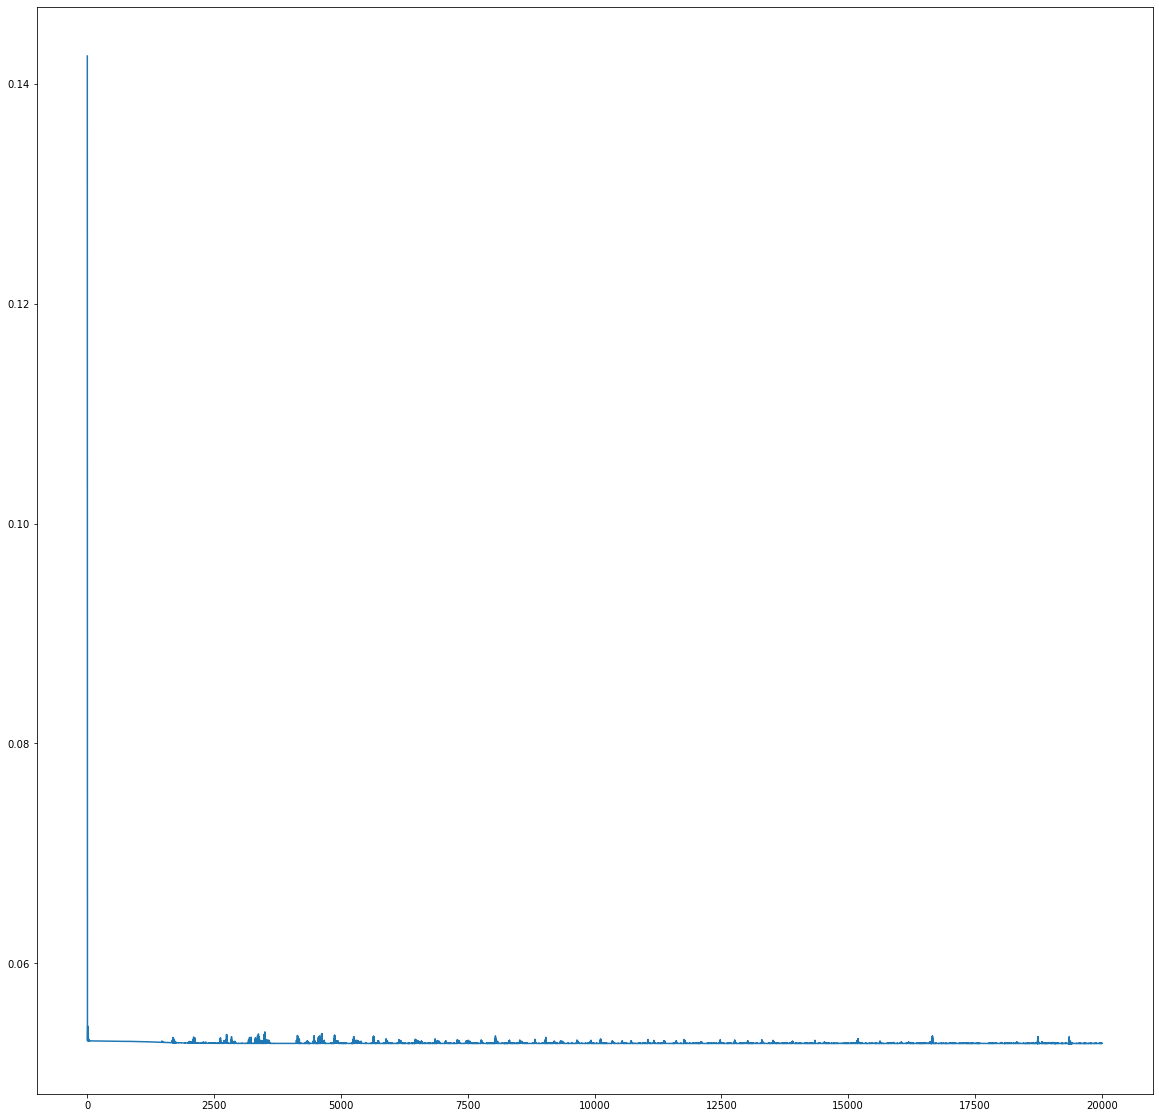

In [75]:
new_tensor = torch.tensor(loss_array, device = 'cpu')
plt.plot(new_tensor)

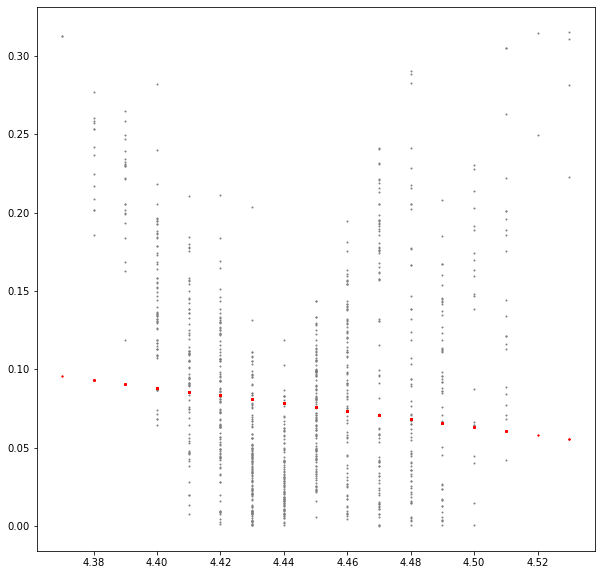

In [76]:
plt.show()
plt.figure(figsize=(10,10))
x = x.cpu().detach().numpy()
y= y.cpu().detach().numpy()
output = output.cpu().detach().numpy()
plt.scatter(x, y, s=1, c="gray")
plt.scatter(x, output, s=1, c="red")
plt.show()

In [56]:
#회귀함수의 기울기가 0일 때 값 즉, optimazing value
x[0], x_poly[0]

(array([4.42000008]), array([ 4.42000008, 19.53640067]))